In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import itertools
import sys
sys.path.insert(0, '..')
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 20)
plt.rcParams['font.size'] = 16
import numpy as np
import pandas as pd
import requests
import seaborn as sns

import covid19

## data

In [3]:
data_italy_regions_path = 'dpc-covid19-ita-regioni.csv'
data_italy_regions_path = covid19.data.download('regioni')
df_italy_regions = pd.read_csv(data_italy_regions_path, parse_dates=['data'], index_col=['data'])

df_italy_regions.index = df_italy_regions.index.normalize()
REGIONS = df_italy_regions.loc[df_italy_regions.index.max()].sort_values('ricoverati_con_sintomi', ascending=False)['denominazione_regione'].tolist()
print(REGIONS)
df_italy_regions.tail()

['Lombardia', 'Emilia-Romagna', 'Piemonte', 'Veneto', 'Lazio', 'Toscana', 'Liguria', 'Marche', 'Puglia', 'Campania', 'Sicilia', 'Abruzzo', 'P.A. Trento', 'P.A. Bolzano', 'Friuli Venezia Giulia', 'Calabria', 'Umbria', 'Sardegna', "Valle d'Aosta", 'Basilicata', 'Molise']


,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en
data,,,,,,,,,,,,,,,,,,
2020-04-04,ITA,9,Toscana,43.769231,11.255889,1129,286,1415,3639,5054,145,172,310,307,5671,47886,NaN,NaN
2020-04-04,ITA,4,P.A. Trento,46.068935,11.121231,353,81,434,1319,1753,94,111,257,210,2220,9863,NaN,NaN
2020-04-04,ITA,10,Umbria,43.106758,12.388247,167,44,211,716,927,7,31,242,41,1210,11809,NaN,NaN
2020-04-04,ITA,2,Valle d'Aosta,45.737503,7.320149,63,23,86,474,560,0,29,106,82,748,2274,NaN,NaN
2020-04-04,ITA,5,Veneto,45.434905,12.338452,1691,324,2015,7078,9093,232,360,1124,607,10824,133289,NaN,NaN


In [4]:
data = {region: df_italy_regions[df_italy_regions['denominazione_regione'] == region] for region in REGIONS}
for dr in data.values():
    dr['variazione_ricoverati_con_sintomi'] = dr['ricoverati_con_sintomi'].diff(1)
    dr['deceduti_attuali'] = dr['deceduti'].diff(1)

df_italy_regions.loc[df_italy_regions.index.max()].sort_values('ricoverati_con_sintomi', ascending=False)[['denominazione_regione', 'ricoverati_con_sintomi', 'terapia_intensiva', 'deceduti']]


,denominazione_regione,ricoverati_con_sintomi,terapia_intensiva,deceduti
data,,,,
2020-04-04,Lombardia,12002,1326,8656
2020-04-04,Emilia-Romagna,3859,358,1977
2020-04-04,Piemonte,3441,450,1128
2020-04-04,Veneto,1691,324,607
2020-04-04,Lazio,1236,193,212
2020-04-04,Toscana,1129,286,307
2020-04-04,Liguria,1121,169,542
2020-04-04,Marche,997,153,574
2020-04-04,Puglia,627,153,173


In [5]:
DAY = np.timedelta64(24 * 60 * 60, 's')
PALETTE_ONE = list(sns.color_palette())

SHOWUNTIL = np.datetime64(df_italy_regions.index.max(), 's') + 2 * DAY

EXTENT = ('2020-02-23', SHOWUNTIL)
XLIM = tuple(map(np.datetime64, EXTENT))

In [6]:
REGIONS_FIT_PARAMS = {
    'Lombardia': {
        'ricoverati_con_sintomi': [None, '2020-03-07', '2020-03-08', '2020-03-18'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Emilia-Romagna': {
        'ricoverati_con_sintomi': [None, '2020-03-02', '2020-03-07', '2020-03-21'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Piemonte': {
        'ricoverati_con_sintomi': [None, '2020-03-20', '2020-03-21', None],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Veneto': {
        'ricoverati_con_sintomi': [None, '2020-03-13', '2020-03-14', '2020-03-24'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Toscana': {
        'ricoverati_con_sintomi': [None, '2020-03-19', '2020-03-27'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Liguria': {
        'ricoverati_con_sintomi': [None, '2020-03-21', '2020-03-27'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Lazio': {
        'ricoverati_con_sintomi': [None, '2020-03-21', '2020-03-28'],
        'terapia_intensiva': 0,
        'deceduti':  ['2020-03-25',],
    },
    'Marche': {
        'ricoverati_con_sintomi': [None, '2020-03-16', '2020-03-21'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Puglia': {
        'ricoverati_con_sintomi': [None, '2020-03-16', '2020-03-26'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Campania': {
        'ricoverati_con_sintomi': [None, '2020-03-26', None],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Sicilia': {
        'ricoverati_con_sintomi': [None, '2020-03-21', None],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'P.A. Trento': {
        'ricoverati_con_sintomi': [None, '2020-03-21', None],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Abruzzo': {
        'ricoverati_con_sintomi': [None, '2020-03-21', None],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Friuli Venezia Giulia': {
        'ricoverati_con_sintomi': [None, '2020-03-16', '2020-03-24', None],
        'terapia_intensiva': 0,
        'deceduti': ['2020-03-20', '2020-03-31', None],
    },
    'P.A. Bolzano': {
        'ricoverati_con_sintomi': [None, '2020-03-21'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Umbria': {
        'ricoverati_con_sintomi': [None, '2020-03-21'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Calabria': {
        'ricoverati_con_sintomi': [None, '2020-03-21'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Sardegna': {
        'ricoverati_con_sintomi': [None, '2020-03-21'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Valle d\'Aosta': {
        'ricoverati_con_sintomi': [None, '2020-03-21'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Basilicata': {
        'ricoverati_con_sintomi': [None, '2020-03-21'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Molise': {
        'ricoverati_con_sintomi': [None, '2020-03-21'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
}

In [7]:
STOP_FIT = '2020-04-03'

region_fits = {}
for region, params in REGIONS_FIT_PARAMS.items():
    region_fits[region] = {}
    for kind, breaks in params.items():
        if isinstance(breaks, int):
            breaks = [np.datetime64(b) + breaks * DAY if b is not None else b for b in params['ricoverati_con_sintomi']]
        region_fits[region][kind] = covid19.fit.fit_exponential_segments(data[region][kind], breaks=breaks)

skipping start=None stop=2020-03-24T00:00:00


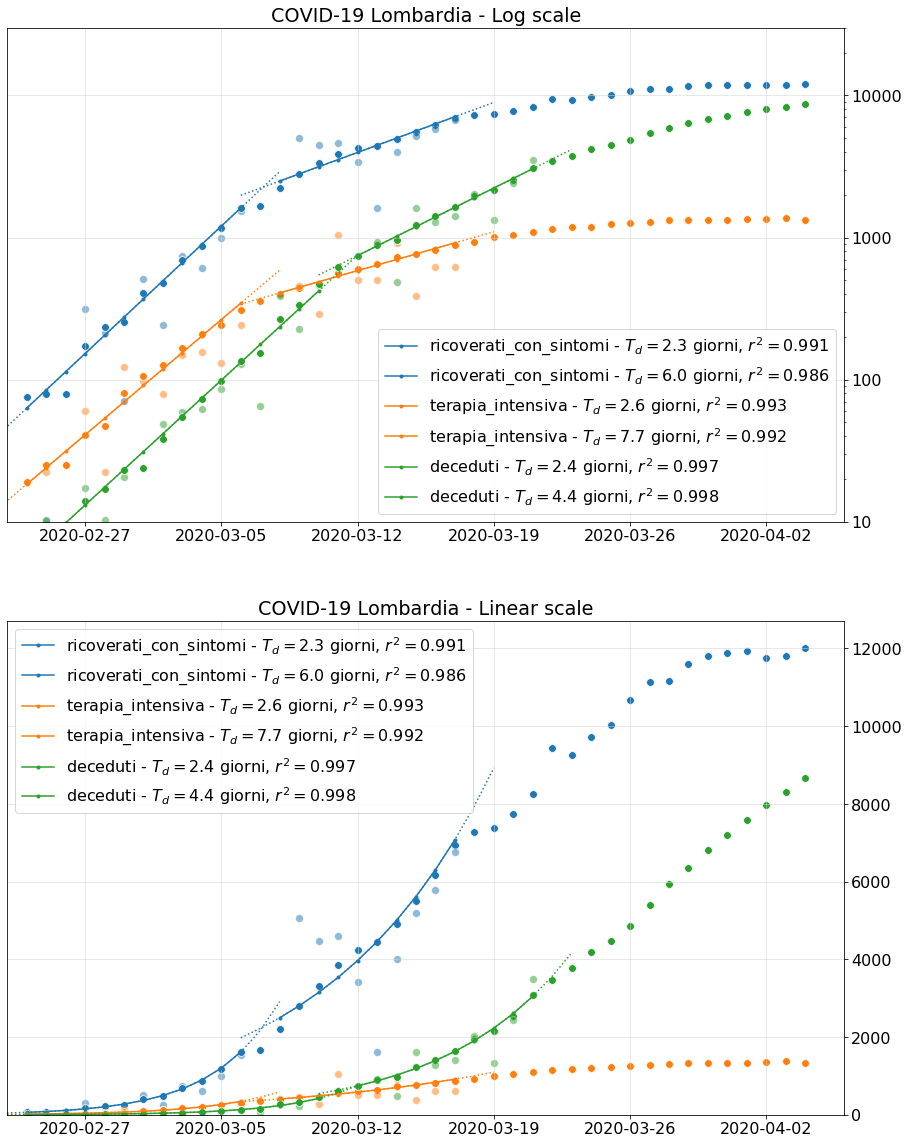

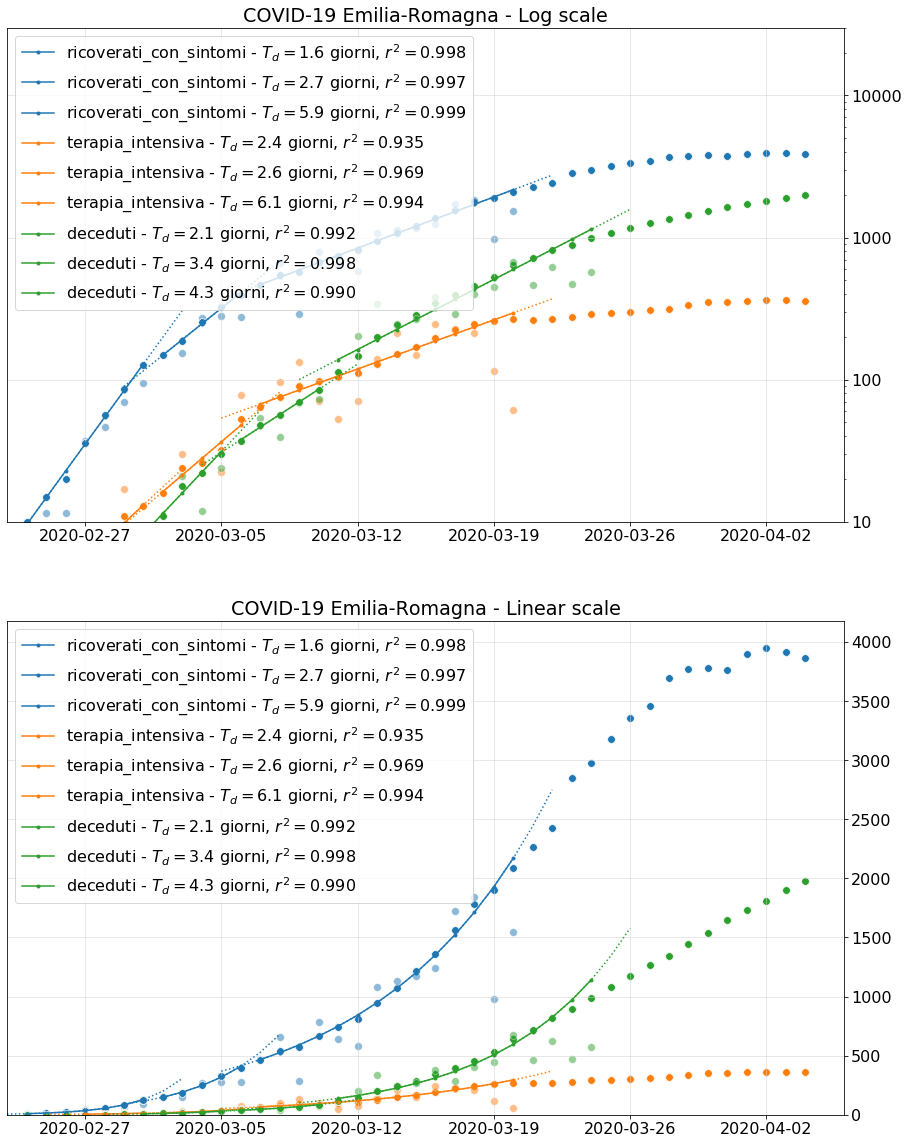

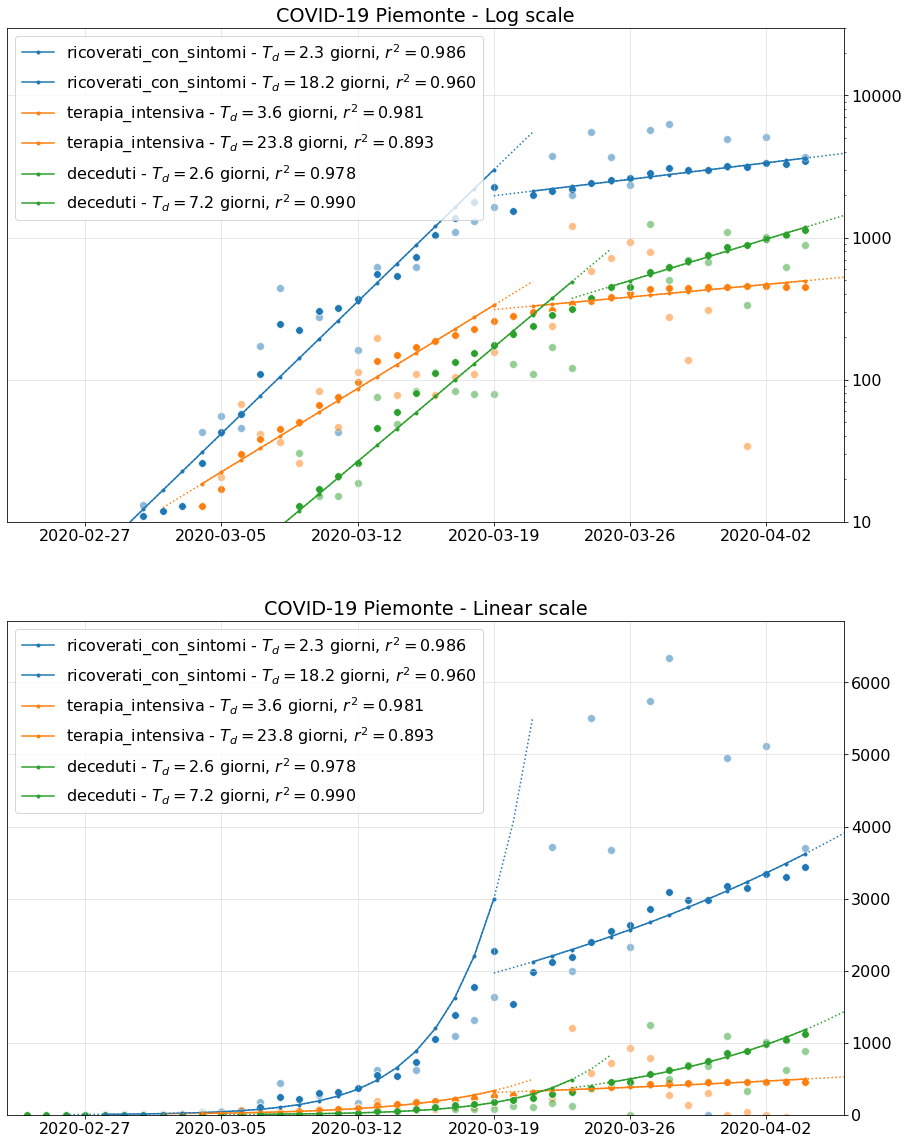

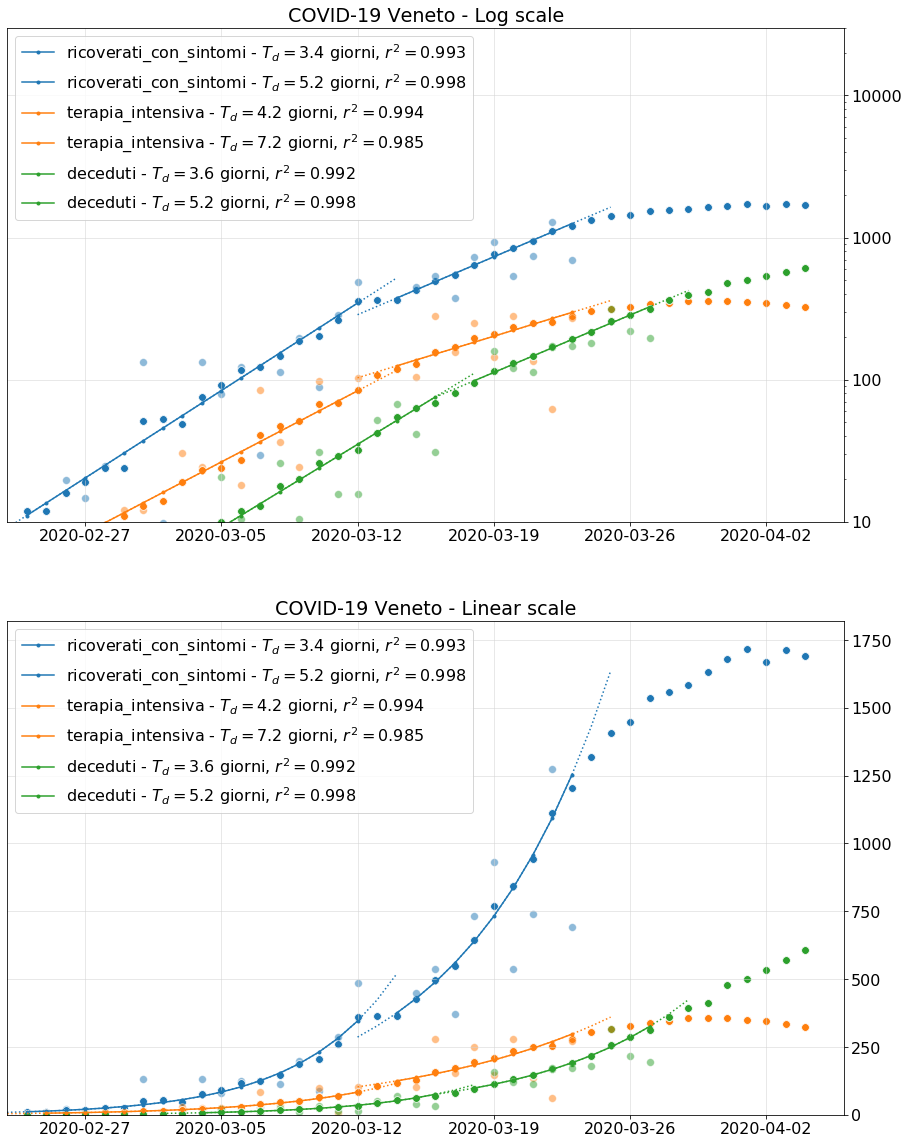

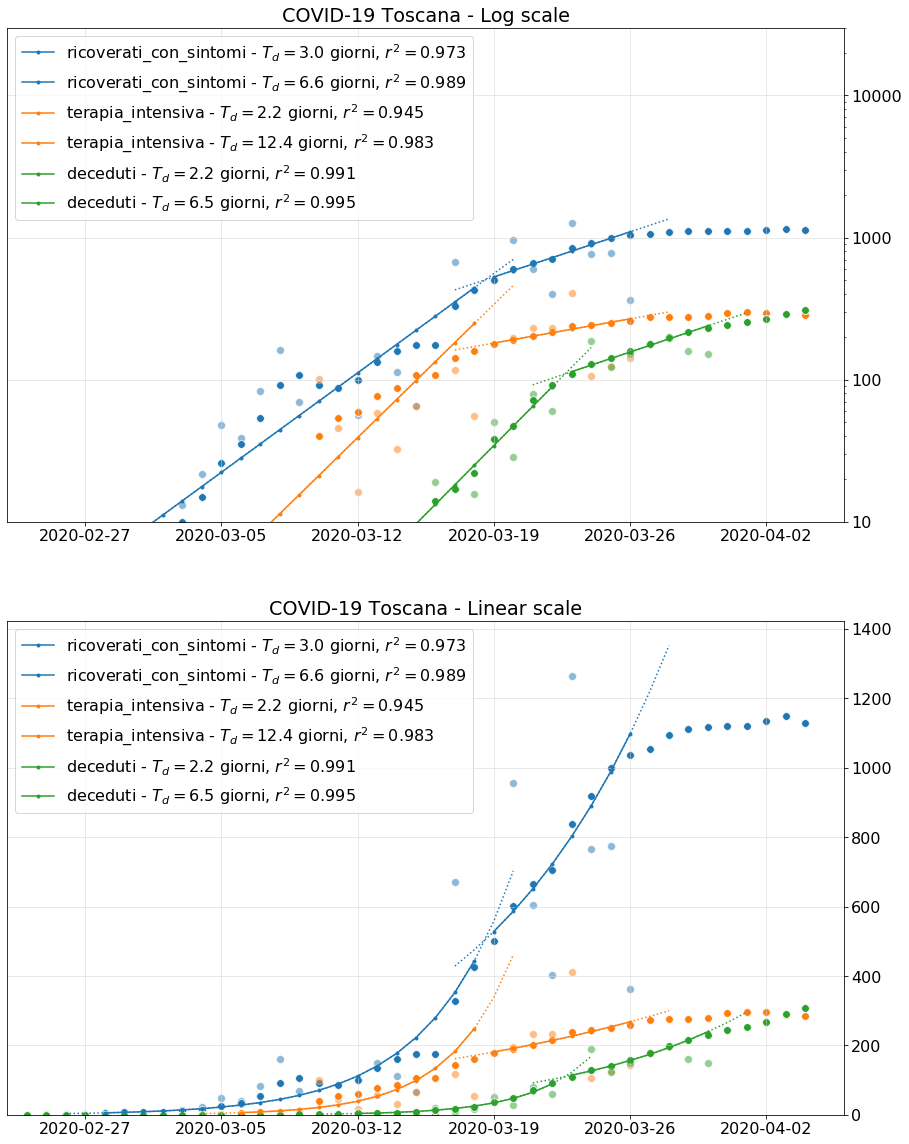

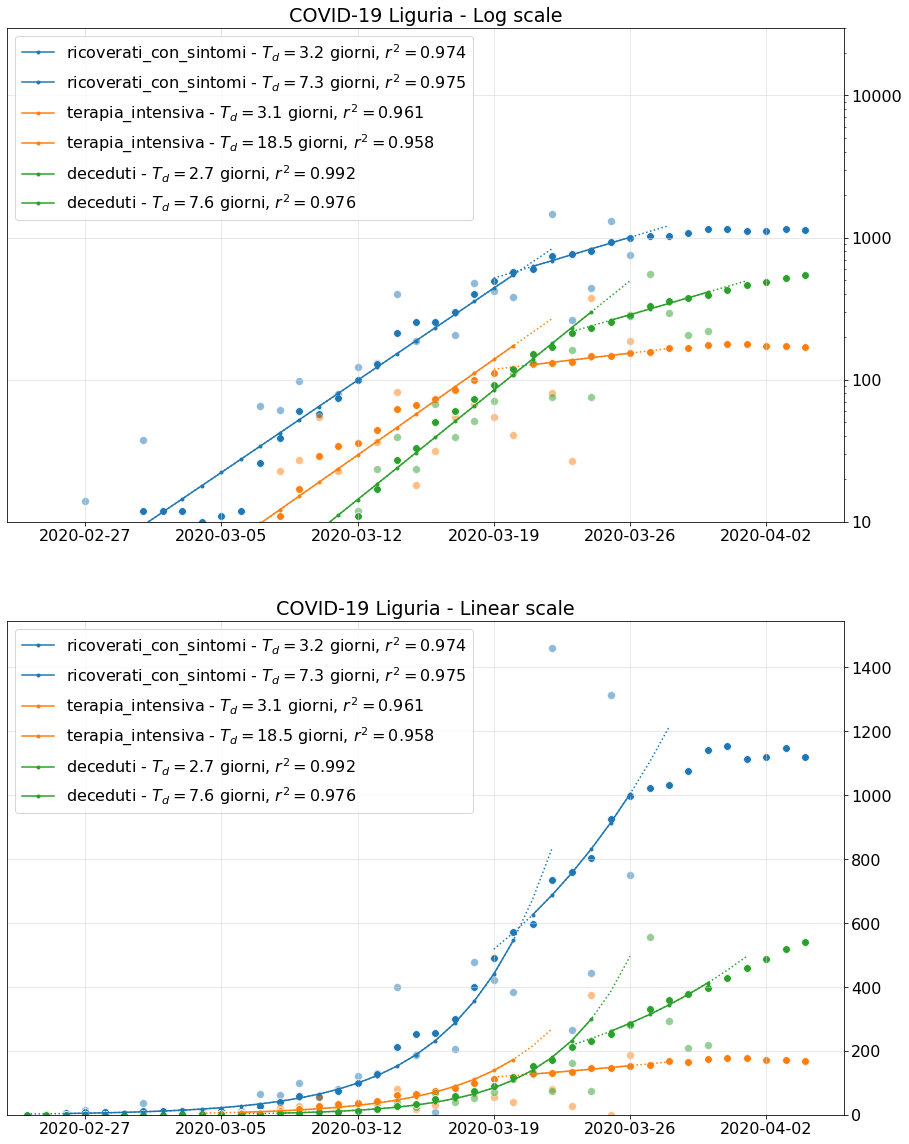

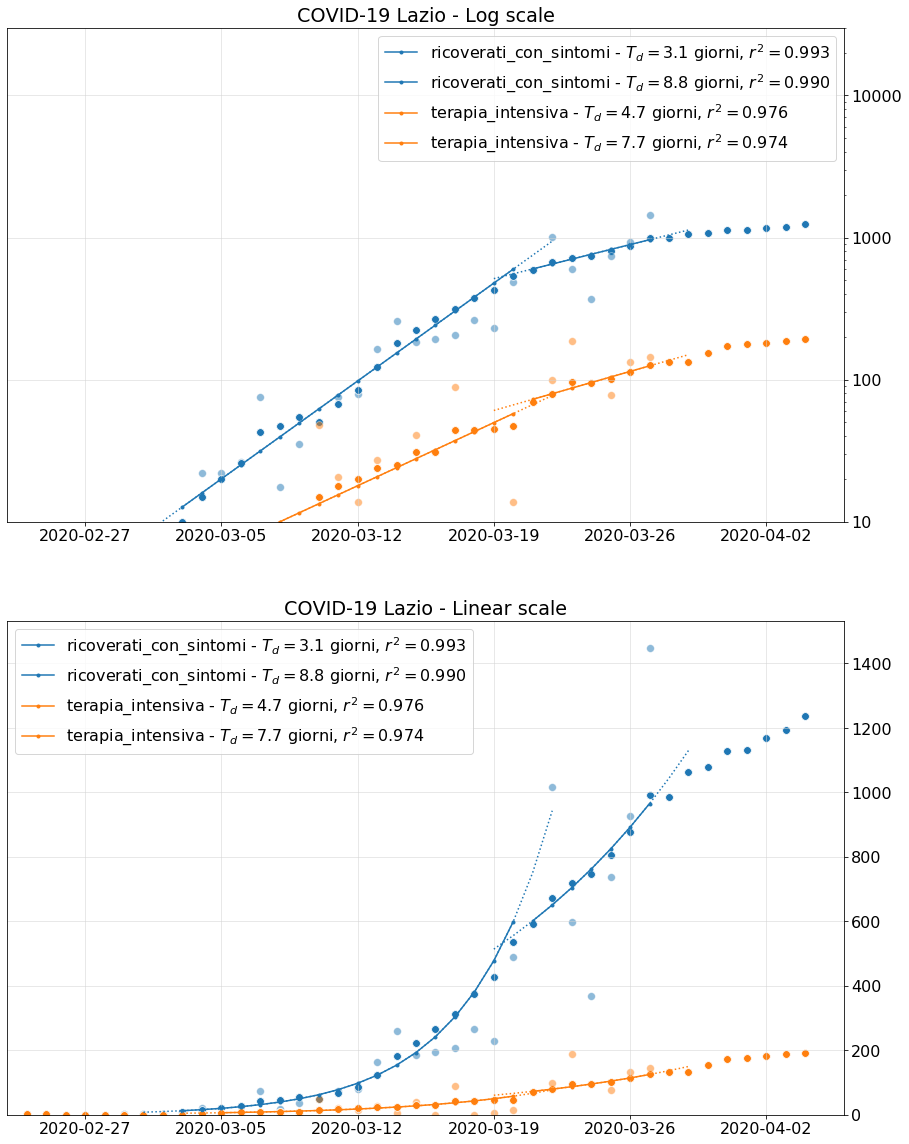

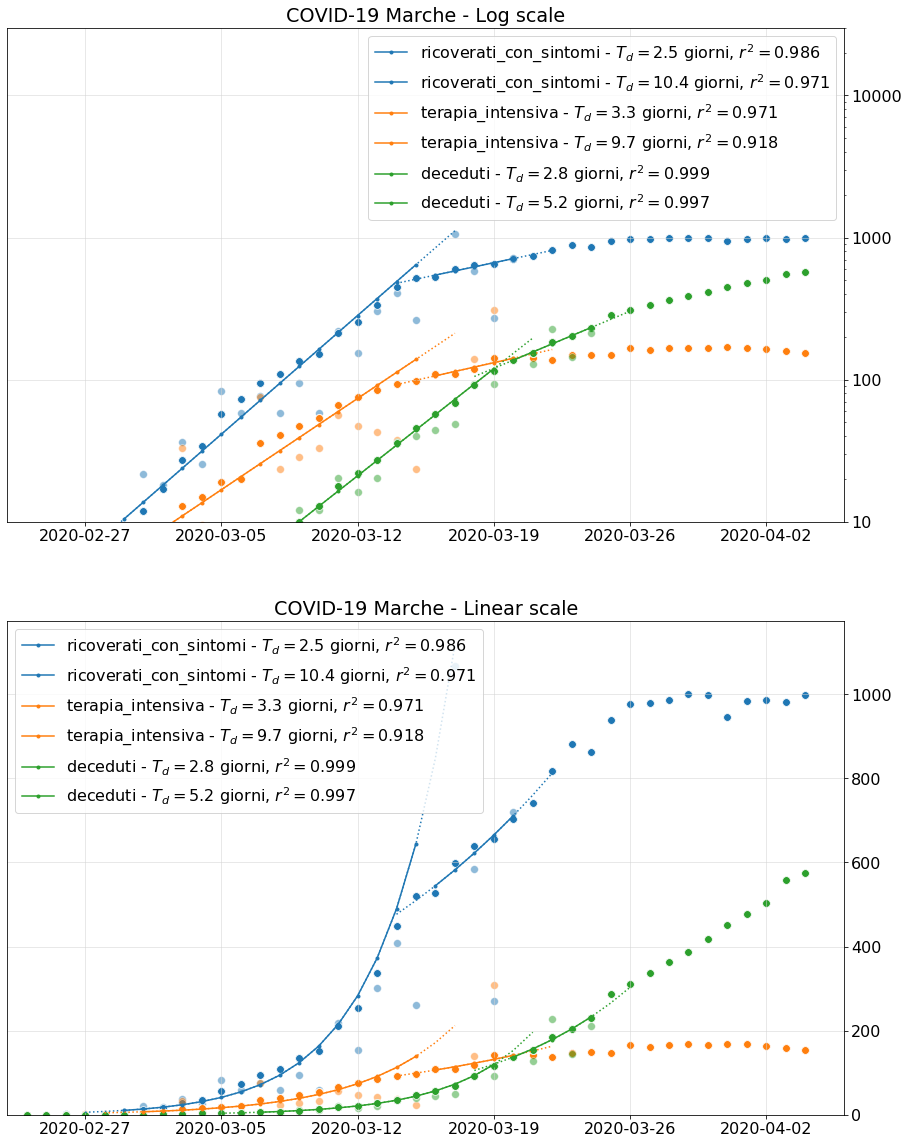

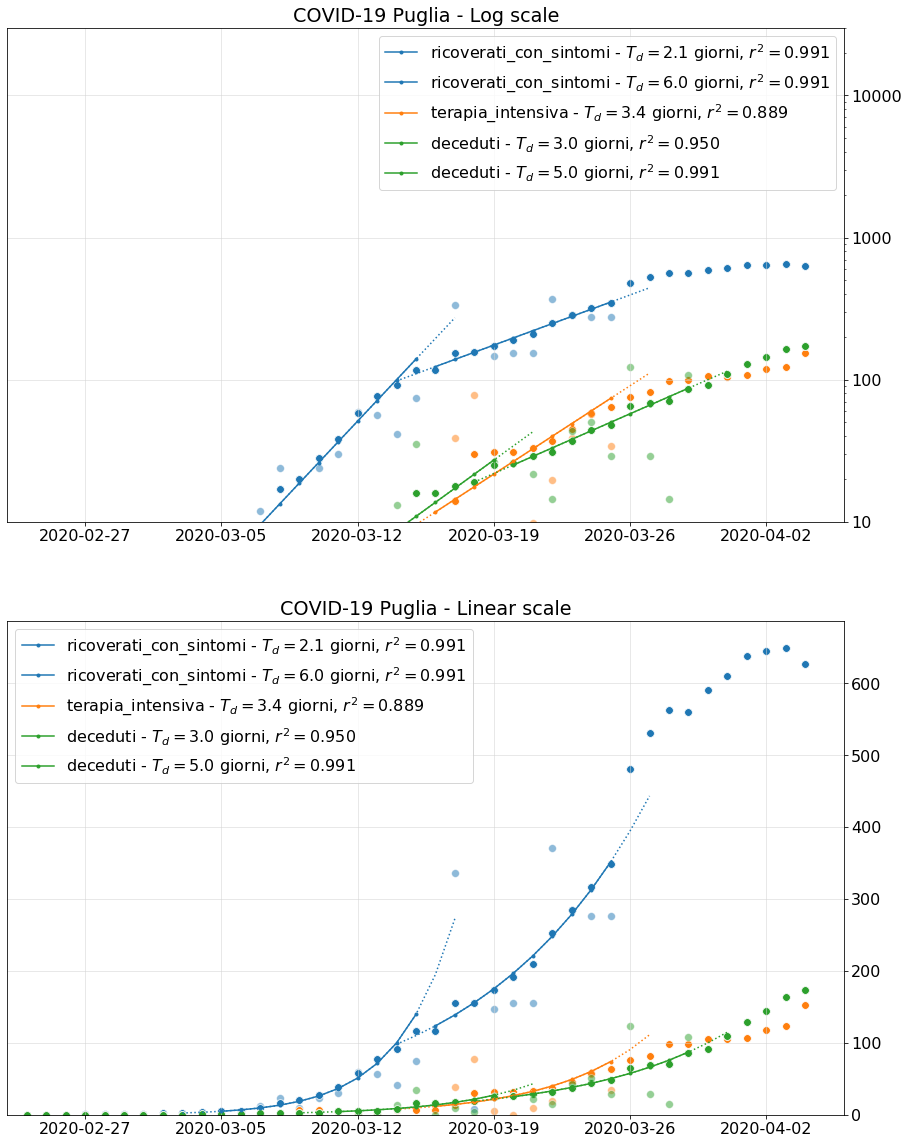

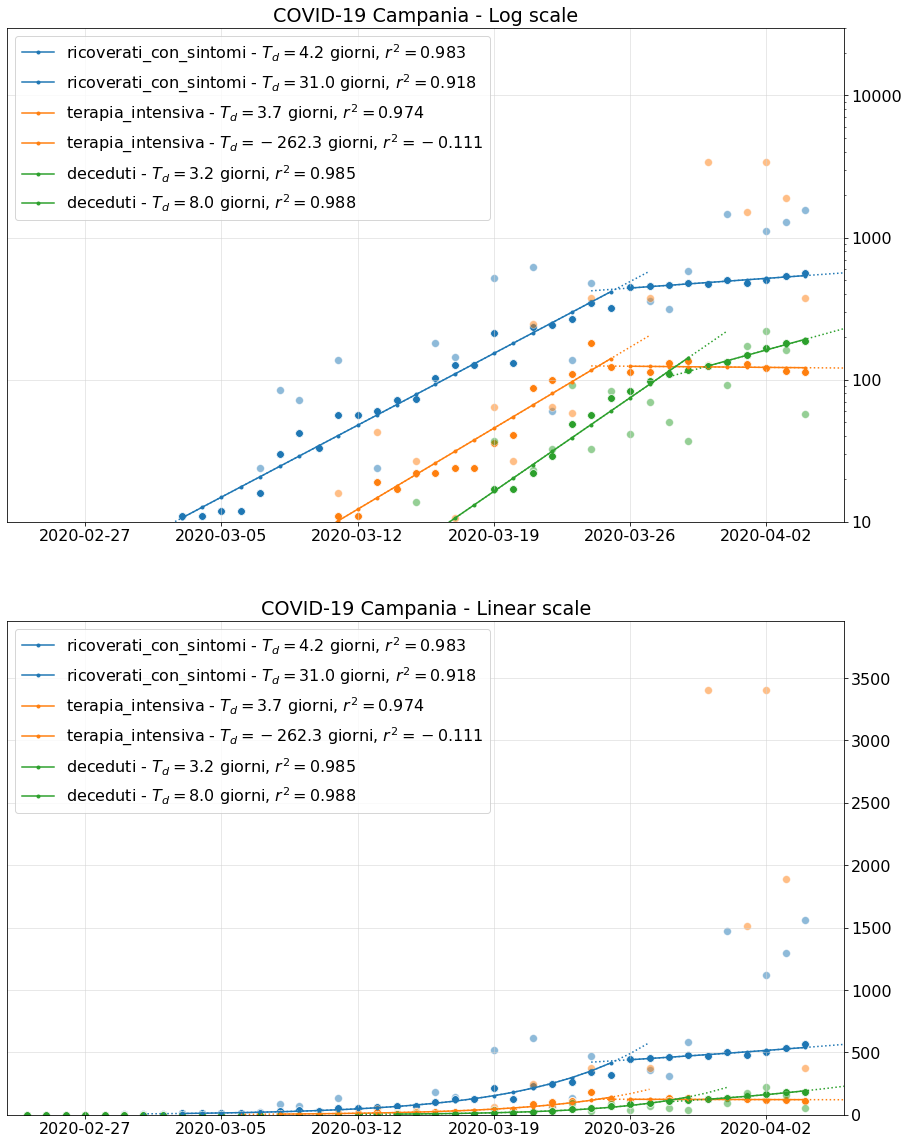

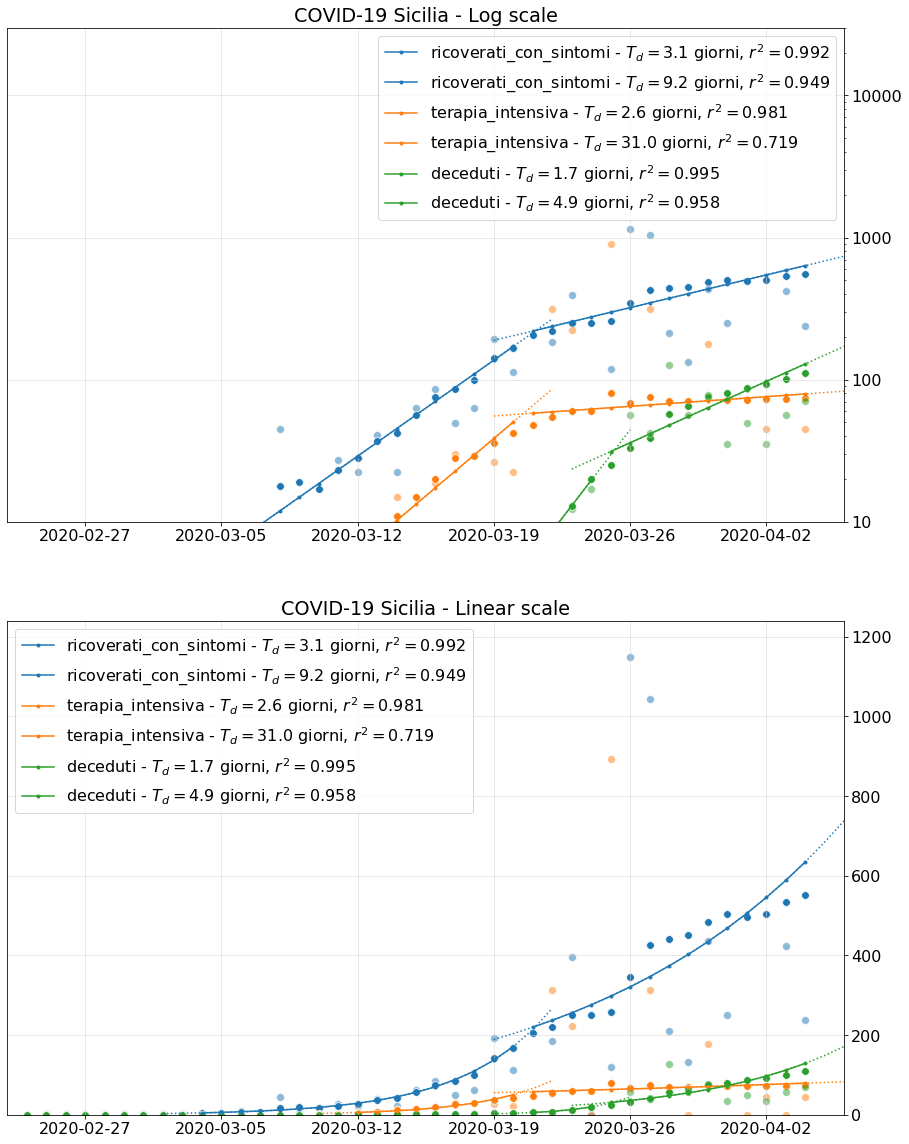

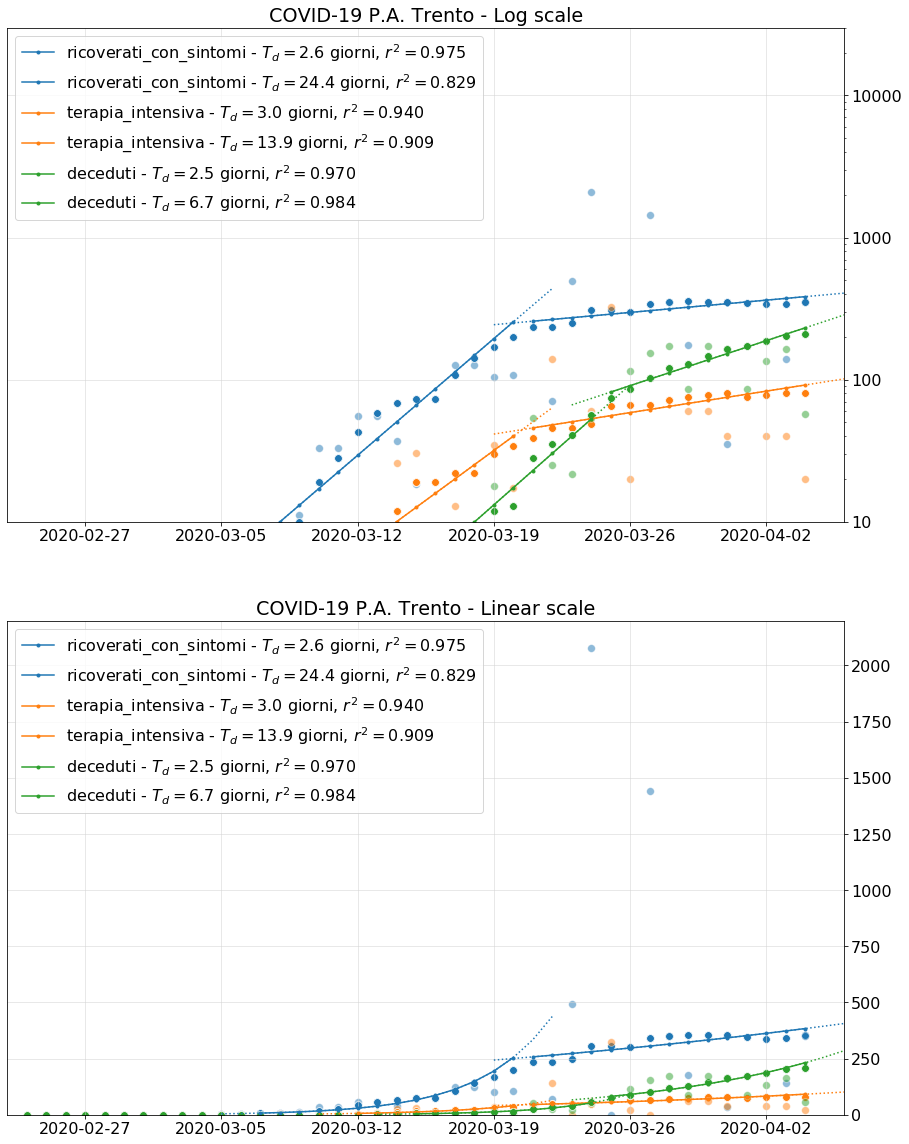

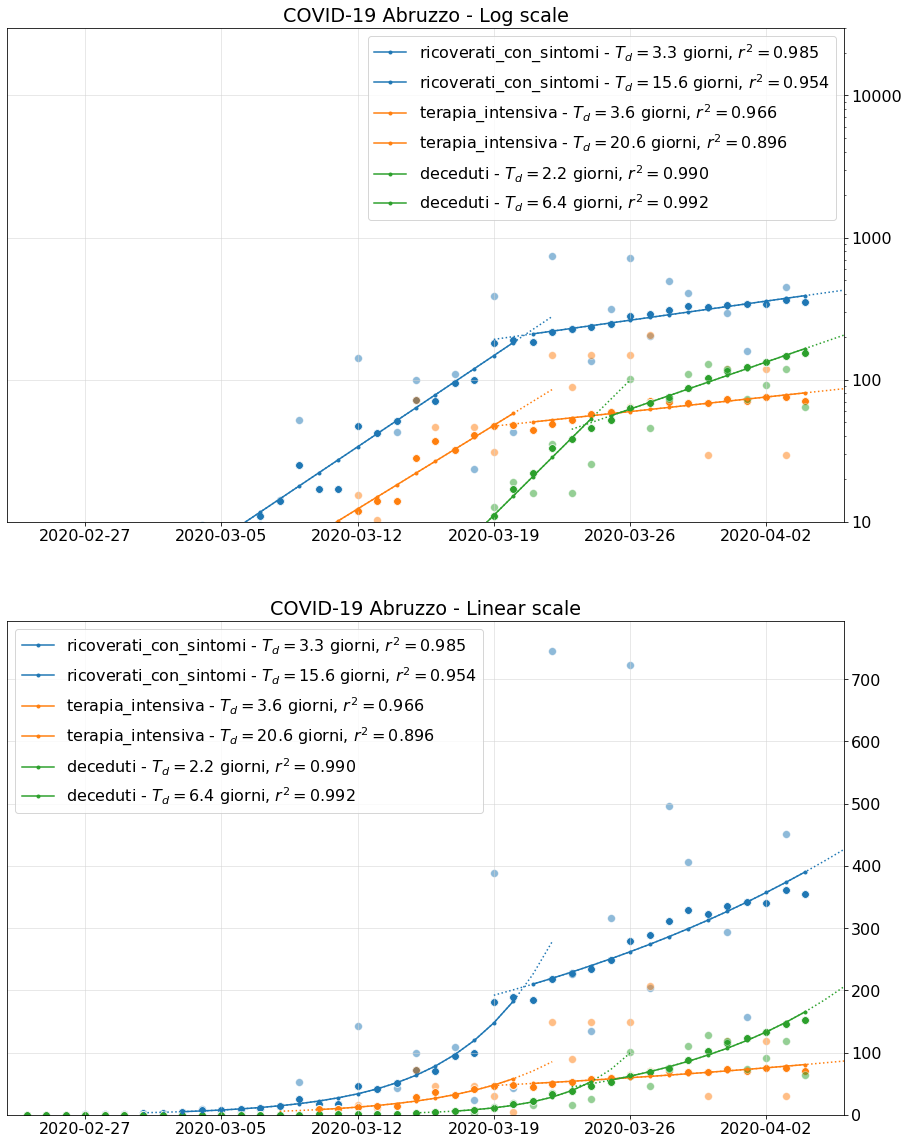

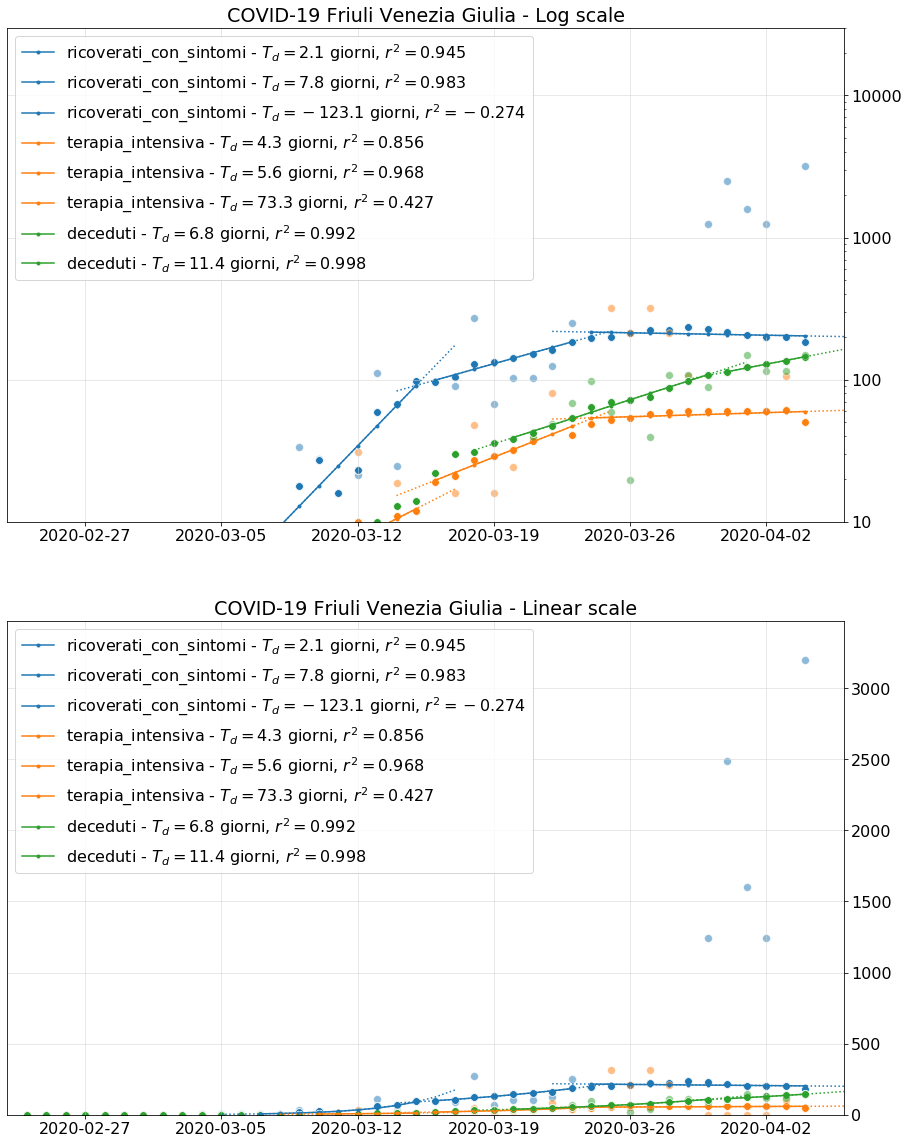

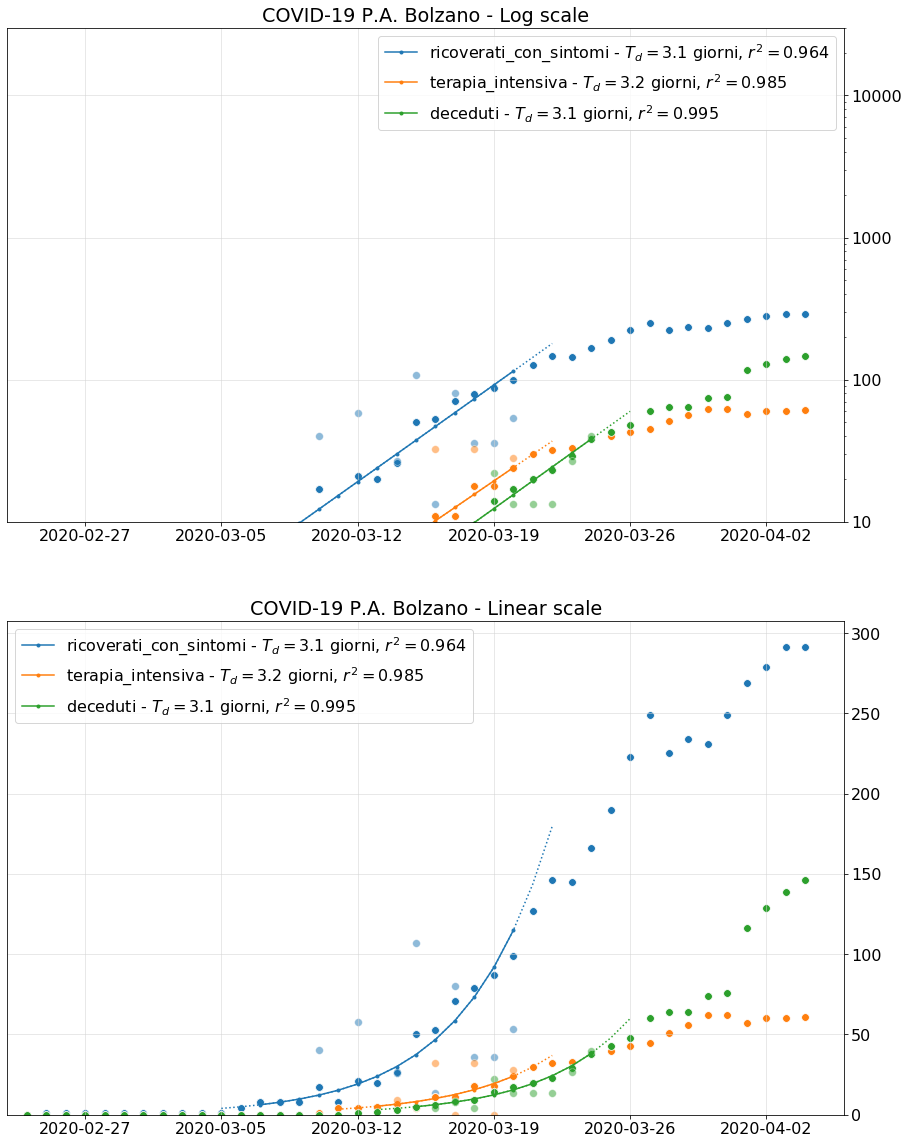

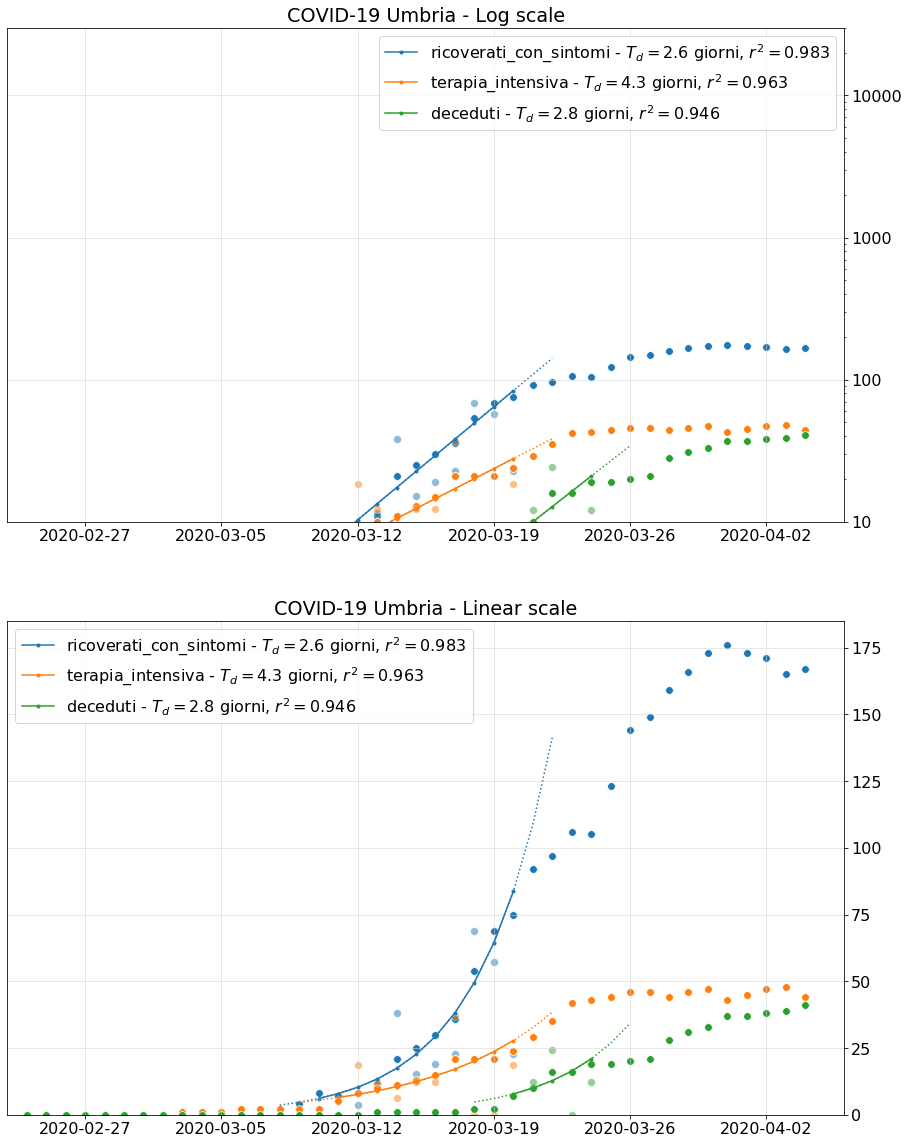

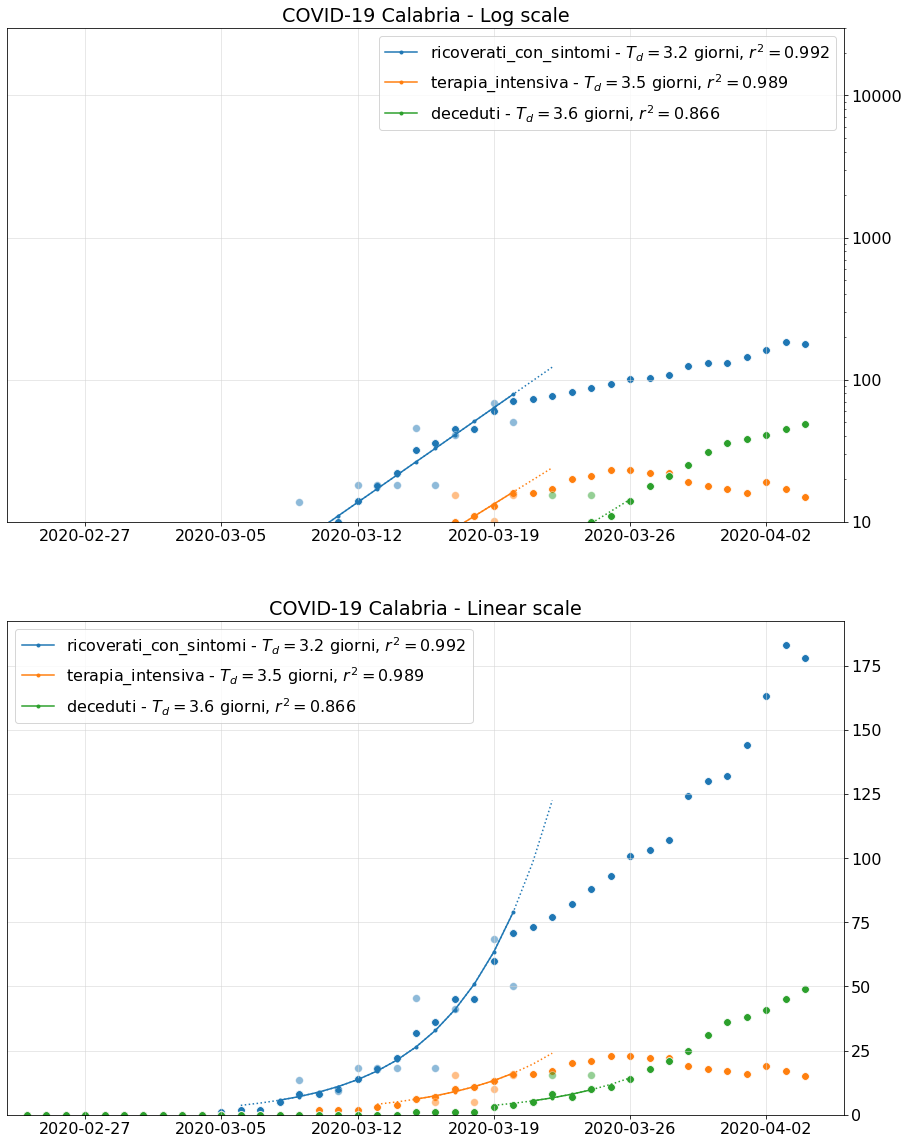

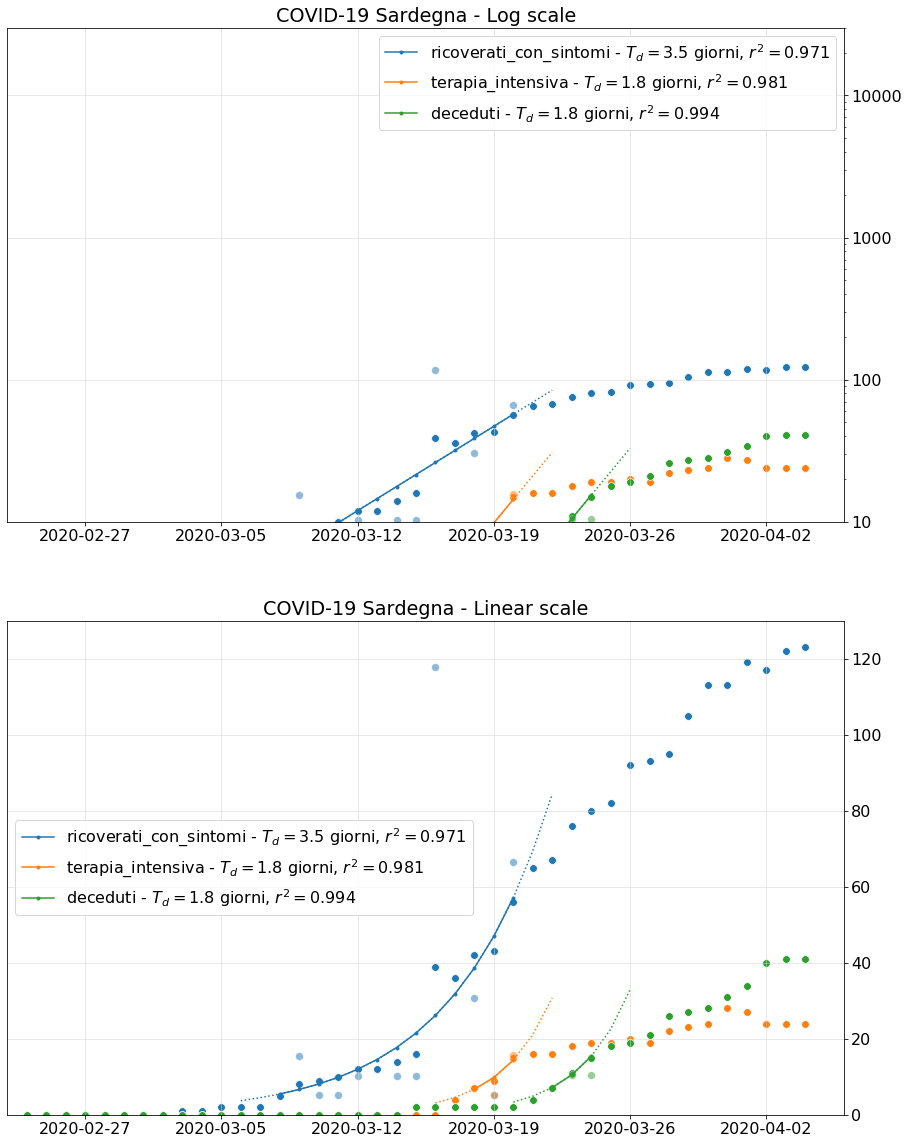

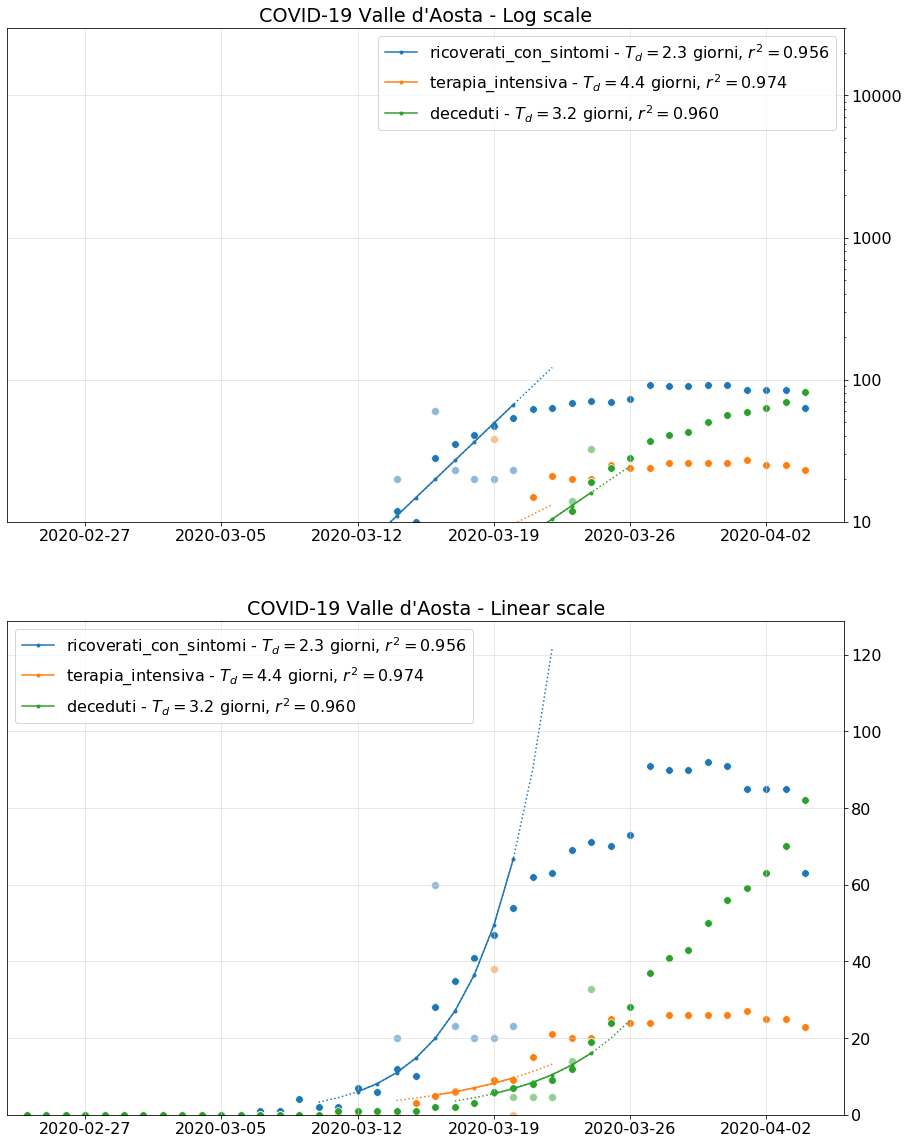

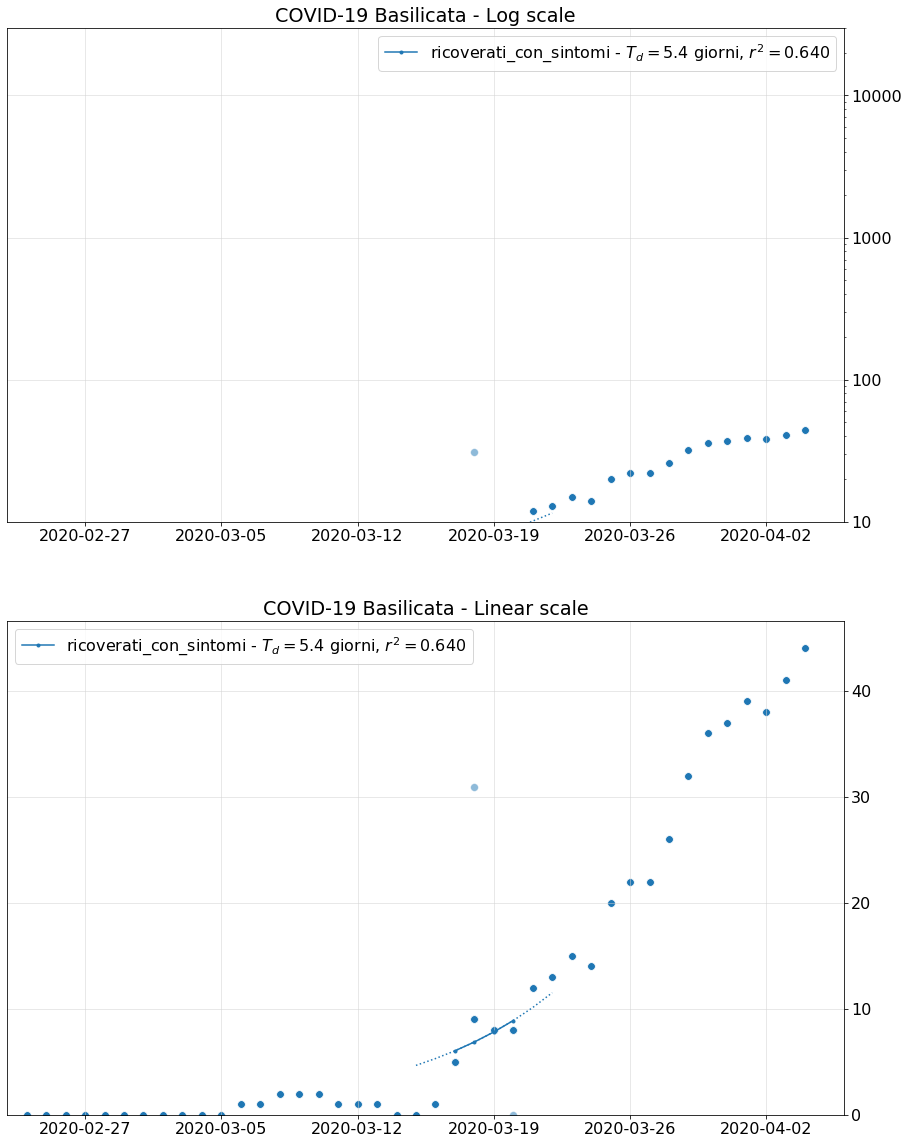

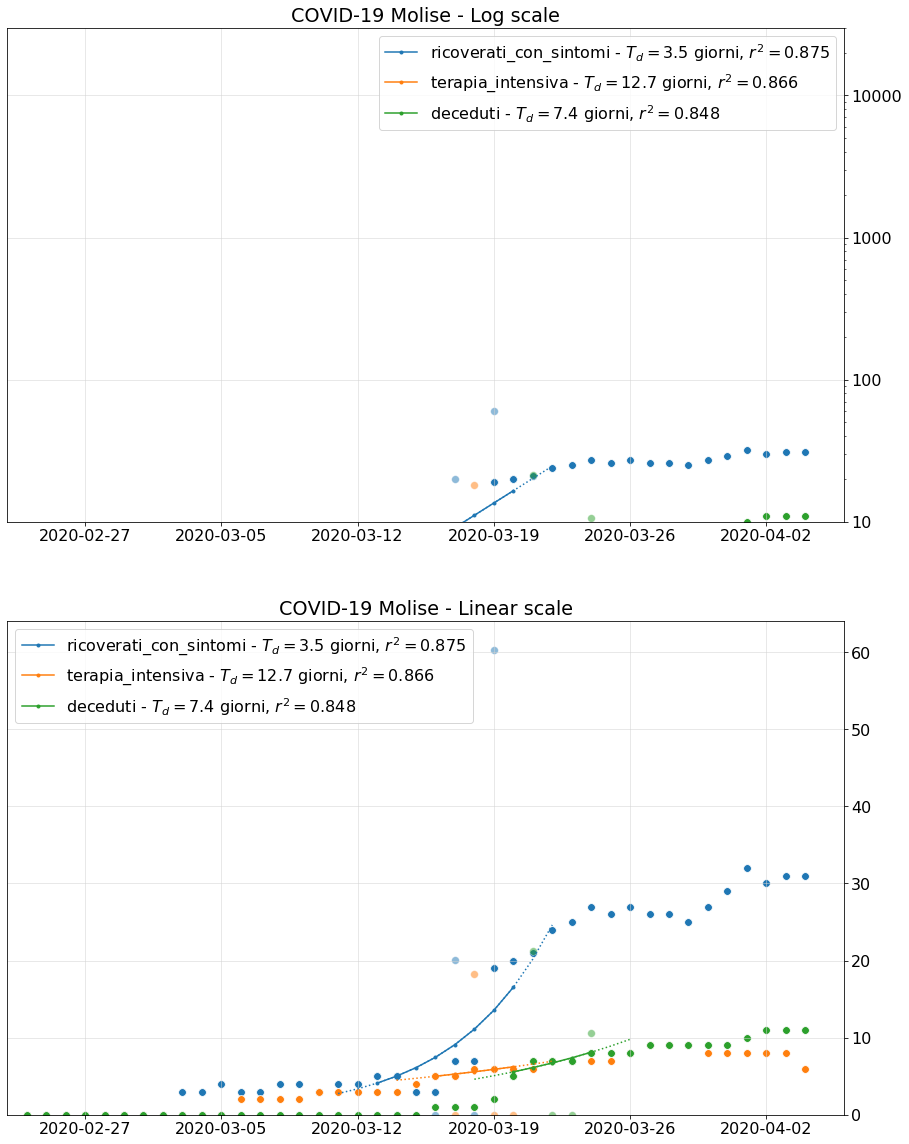

In [8]:
for region, fit_kinds in list(region_fits.items()):
    _, ax = plt.subplots(2, subplot_kw={'xlim': XLIM})
    ax[0].set(yscale='log', ylim=(10, 30000)) 
    ax[0].set_title(f'COVID-19 {region} - Log scale')
    ax[0].yaxis.tick_right()
    ax[0].yaxis.grid(color='lightgrey', linewidth=0.5)
    ax[0].xaxis.grid(color='lightgrey', linewidth=0.5)

    ax[1].set_title(f'COVID-19 {region} - Linear scale')
    ax[1].yaxis.tick_right()
    ax[1].yaxis.grid(color='lightgrey', linewidth=0.5)
    ax[1].xaxis.grid(color='lightgrey', linewidth=0.5)

    for (kind, fits), color in zip(fit_kinds.items(), PALETTE_ONE):
        for fit in fits:
            covid19.plot.plot_data(ax[0], data[region][kind], color=color)
            covid19.plot.plot(ax[0], data[region][kind], fit, label=kind, color=color, date_interval=5)
            covid19.plot.plot_data(ax[1], data[region][kind], color=color)
            covid19.plot.plot(ax[1], data[region][kind], fit, label=kind, color=color, date_interval=5)

    ax[1].set(ylim=(0, None)) 

In [9]:
for region, fit_kinds in region_fits.items():
    _, ax = plt.subplots(subplot_kw={'ylim': (0, data_italy_regions[region]['ricoverati_con_sintomi'].max() * 1.1), 'xlim': XLIM}, figsize=(14, 8))
    ax.yaxis.grid(color='lightgrey', linewidth=0.5)
    ax.xaxis.grid(color='lightgrey', linewidth=0.5)
    ax.set_title(f'COVID-19 {region}')
    ax.yaxis.tick_right()
    ax.legend(loc='top left')

    for (kind, fits), color in zip(fit_kinds.items(), PALETTE_ONE):
        if kind in ['terapia_intensiva', 'deceduti']:
            continue
        covid19.plot.plot_data(ax, data_italy_regions[region][kind], color=color, show_left=True, show_right=True)
        for fit in fits:
            covid19.plot.plot(ax, data_italy_regions[region][kind], fit, label=kind, color=color)


NameError: name 'data_italy_regions' is not defined

In [ ]:
print('## Initial exponential speed')
for region, fit_kinds in region_fits.items():
    if len(fit_kinds['deceduti']):
        print(f'{region}:{" " * (14 - len(region))} {str(fit_kinds["deceduti"][0])}')

In [ ]:
print('## Current exponential speed')
for region, fit_kinds in region_fits.items():
    if len(fit_kinds['deceduti']):
        print(f'{region}:{" " * (14 - len(region))} {str(fit_kinds["deceduti"][-1])}')